<a href="https://colab.research.google.com/github/rmartinshort/FruitClassification/blob/master/KERAS_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is an example of using Keras for transfer learning on a dataset of fruits. 

This notebook is used to train a CNN to recognize various categories of fruit. We use CoLab because of the free GPU and access to TensorBoard, which is helpful for analysing model performance

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import backend as K
from keras.callbacks import TensorBoard
from keras import optimizers
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import glob
import numpy as np

In [0]:
mv ../test_for_CNN1.zip .

mv: cannot stat '../test_for_CNN1.zip': No such file or directory


In [0]:
!unzip test_for_CNN1.zip

Archive:  test_for_CNN1.zip
replace test_for_CNN1/train/asterix_potato/asterix_potato_045.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 1.14.0 , GPU: /device:GPU:0


In [0]:
train_dir = 'test_for_CNN1/train/'
val_dir = 'test_for_CNN1/val'
BATCH_SIZE = 20
HEIGHT = 224
WIDTH = 224 
N_EPOCHS = 30

In [0]:
#Load the base model 
base_model = VGG16(weights='imagenet',include_top=False,input_shape=(HEIGHT,WIDTH,3))

In [0]:
#Image augmentation for the training dataset. This could be adjusted to improve accurcy and prevent overfitting
#Remember to rescale the image!!

datagen_train = ImageDataGenerator(     
        rescale=1. / 255,
        horizontal_flip=True,
        rotation_range=90,
        vertical_flip=True,
        fill_mode='nearest')

#Image processing only for the test dataset
datagen_val = ImageDataGenerator(
        rescale=1. / 255)


In [0]:
train_generator = datagen_train.flow_from_directory(train_dir,target_size=(HEIGHT,WIDTH),batch_size=BATCH_SIZE,class_mode='categorical',shuffle=True)

Found 1850 images belonging to 15 classes.


In [0]:
#Dictionary of class labels to use
classes_dict = train_generator.class_indices

In [0]:
classes_dict

{'agata_potato': 0,
 'asterix_potato': 1,
 'cashew': 2,
 'diamond_peach': 3,
 'fuji_apple': 4,
 'granny_smith_apple': 5,
 'honneydew_melon': 6,
 'kiwi': 7,
 'nectarine': 8,
 'onion': 9,
 'orange': 10,
 'plum': 11,
 'spanish_pear': 12,
 'taiti_lime': 13,
 'watermelon': 14}

In [0]:
test_generator = datagen_val.flow_from_directory(val_dir,target_size=(HEIGHT,WIDTH),class_mode='categorical',shuffle=False)

Found 783 images belonging to 15 classes.


In [0]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
  
    ''' This generates a model whose final layer can be retrained as in transfer
    learning '''
    
    
    #Prevent the CNN layers from being trainable
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model
 

def load_image(img_path, show=False):
  
    '''Load an image for viewing'''

    img = load_img(img_path, target_size=(HEIGHT, WIDTH))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [0]:
class_list = sorted(glob.glob('test_for_CNN1/train/*'))
classes = [x.split('/')[-1] for x in class_list]


In [0]:
classes

['agata_potato',
 'asterix_potato',
 'cashew',
 'diamond_peach',
 'fuji_apple',
 'granny_smith_apple',
 'honneydew_melon',
 'kiwi',
 'nectarine',
 'onion',
 'orange',
 'plum',
 'spanish_pear',
 'taiti_lime',
 'watermelon']

In [0]:
FC_LAYERS = [4096,4096]

#May want to use dropout to reduce overfitting, but we can experiment with this
dropout = 0

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [0]:
finetune_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# compile the model 
finetune_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.0001), metrics=["accuracy"])

### Here we're training the model and testing on the validation dataset

In [0]:
import tensorflow as tf

step_size_train=train_generator.n//train_generator.batch_size
step_size_test=test_generator.n//test_generator.batch_size

with tf.device("/device:GPU:0"):
    history_pretrained = finetune_model.fit_generator(
    train_generator,
    epochs=N_EPOCHS, 
    shuffle = True, 
    verbose = 1,
    steps_per_epoch=step_size_train,
    validation_data = test_generator, 
    validation_steps=step_size_test)

Epoch 1/30
92/92 [==============================] - 49s 529ms/step - loss: 1.5890 - acc: 0.5391 - val_loss: 0.6612 - val_acc: 0.8021
Epoch 2/30
92/92 [==============================] - 43s 465ms/step - loss: 0.4712 - acc: 0.8587 - val_loss: 0.4349 - val_acc: 0.8589
Epoch 3/30
92/92 [==============================] - 43s 469ms/step - loss: 0.3828 - acc: 0.8690 - val_loss: 0.2389 - val_acc: 0.9254
Epoch 4/30
92/92 [==============================] - 43s 470ms/step - loss: 0.2614 - acc: 0.9087 - val_loss: 0.2690 - val_acc: 0.9108
Epoch 5/30
92/92 [==============================] - 43s 465ms/step - loss: 0.1996 - acc: 0.9342 - val_loss: 0.1948 - val_acc: 0.9241
Epoch 6/30
92/92 [==============================] - 43s 468ms/step - loss: 0.1891 - acc: 0.9337 - val_loss: 0.1327 - val_acc: 0.9574
Epoch 7/30
92/92 [==============================] - 43s 470ms/step - loss: 0.1942 - acc: 0.9288 - val_loss: 0.2772 - val_acc: 0.9148
Epoch 8/30
92/92 [==============================] - 43s 467ms/step - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


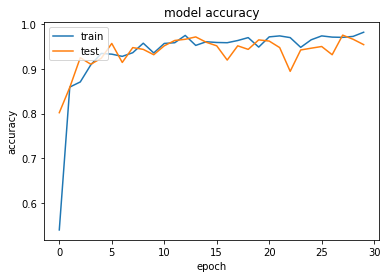

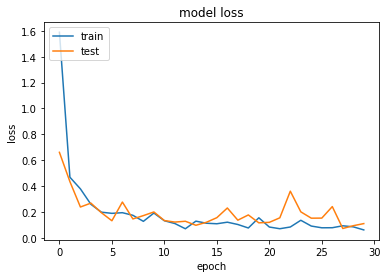

In [0]:
#Lets take look at the evolution of the validation error over time

# list all data in history
print(history_pretrained.history.keys())
# summarize history for accuracy
plt.plot(history_pretrained.history['acc'])
plt.plot(history_pretrained.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Manual assessment of the accuracy of the model

In [0]:
fruits_accuracy_dict = classes_dict.copy()

for fruit in classes_dict:
  
  print(f'Dealing with fruit {fruit}')
  
  #get the known class
  correct_class = classes_dict[fruit]
  
  correct_classes = 0
  i = 0
  
  for test_image in glob.glob('test_for_CNN1/val/%s/*' %fruit):
    
    input_image = load_image(test_image,show=False)
    # check prediction
    pred = finetune_model.predict(input_image)
    #get the class
    myclass = np.argmax(pred)
    if myclass == correct_class:
      correct_classes += 1

    i+=1
   
  fruits_accuracy_dict[fruit] = correct_classes/i


Dealing with fruit agata_potato
Dealing with fruit asterix_potato
Dealing with fruit cashew
Dealing with fruit diamond_peach
Dealing with fruit fuji_apple
Dealing with fruit granny_smith_apple
Dealing with fruit honneydew_melon
Dealing with fruit kiwi
Dealing with fruit nectarine
Dealing with fruit onion
Dealing with fruit orange
Dealing with fruit plum
Dealing with fruit spanish_pear
Dealing with fruit taiti_lime
Dealing with fruit watermelon


#### The following displays the class accuracies. They should be pretty good!

In [0]:
fruits_accuracy_dict

{'agata_potato': 0.9833333333333333,
 'asterix_potato': 0.8703703703703703,
 'cashew': 1.0,
 'diamond_peach': 0.9206349206349206,
 'fuji_apple': 0.9682539682539683,
 'granny_smith_apple': 1.0,
 'honneydew_melon': 1.0,
 'kiwi': 0.9803921568627451,
 'nectarine': 0.9864864864864865,
 'onion': 0.5454545454545454,
 'orange': 1.0,
 'plum': 0.9873417721518988,
 'spanish_pear': 0.8297872340425532,
 'taiti_lime': 0.967741935483871,
 'watermelon': 1.0}